# Analysis of the activation of the Llama model and its K-Neuron variants

In [ ]:
import torch
import random
import torch.nn as nn
from transformers import LlamaForCausalLM, AutoTokenizer
from topk_models import TopKLlamaForCausalLM, TopKLlamaConfig
from transformers.models.llama.modeling_llama import LlamaForCausalLM
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np

# Configurations of this notobook
MODEL_PATH = 'models/Llama-2-7b-hf'
MODEL_TYPE = 'original'
DATA_PATH = './data/alpaca/'
N_SAMPLES = 20
if MODEL_TYPE == 'original':
    model = LlamaForCausalLM.from_pretrained("./models/Llama-2-7b-hf/", device_map="auto")
else:
    config = TopKLlamaConfig.from_json_file('7b_base_configs.json')
    model = TopKLlamaForCausalLM.from_pretrained(
        "./models/Llama-2-7b-hf/", 
        device_map="auto",
        config=config
    )
tokenizer = AutoTokenizer.from_pretrained("./models/Llama-2-7b-hf/")
model.eval()

Sample some data points from the instruction-tuning data, e.g., Alpaca52K

In [ ]:
import random
from datasets import load_dataset
data = load_dataset(DATA_PATH)['train']
data_idx_sample = random.sample([_ for _ in range(len(data))], N_SAMPLES)
data_samples = [data[i] for i in data_idx_sample]

Register the forwardhook for recording activation

In [ ]:
n_layer = 32
hidden_inp = {
    "gate_proj": [[] for _ in range(n_layer)], "up_proj": [[] for _ in range(n_layer)], "down_proj": [[] for _ in range(n_layer)]
}
hidden_out = {
    "gate_proj": [[] for _ in range(n_layer)], "up_proj": [[] for _ in range(n_layer)], "down_proj": [[] for _ in range(n_layer)]
}

def forward_input_hook(name, layer_id):
    def fn(module: nn.Module, inp, out):
        hidden_inp[name][layer_id].append(inp)
    return fn

def forward_output_hook(name, layer_id):
    def fn(module: nn.Module, input, output):
        hidden_out[name][layer_id].append(inp)
    return fn
            
for n, m in model.named_modules():
    if len(n.split(".")) < 5:
        continue
    layer_id = int(n.split(".")[2])
    name = n.split(".")[-1]
    if "LlamaMLP" in n.split("."):
        m.register_forward_hook(forward_input_hook(name, layer_id))
        m.register_forward_hook(forward_output_hook(name, layer_id)) 

In [ ]:
for d in tqdm(data_samples):
    inp = prompt.format_map(d)
    out = f"{d['output']}{tokenizer.eos_token}"
    text = inp + out
    # tokenize
    input_ids = tokenizer(text, return_tensors='pt').input_ids # .to(device)
    # forward
    y = model(input_ids[:,:-1])

## Analysis of the activation

1. Q1: how many neurons are activated by an activation value that is larger than T?

NameError: name 'n_layer' is not defined

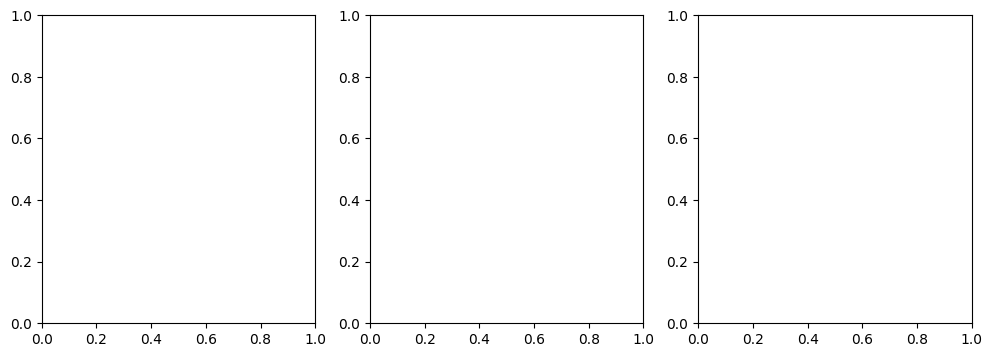

: 

In [4]:
import matplotlib.pyplot as plt
T_lists = [0.1, 0.01, 0.001]
tot = gate_h[0][0].shape[0] *  gate_h[0][0].shape[1] *  gate_h[0][0].shape[2] 
fig, axes = plt.subplots(1, len(T_lists), figsize=(12, 4))
for n, T in enumerate(T_lists):
    gate_act_rate = []
    for i in range(n_layer):
        after_act = F.silu(gate_h[i][0]).detach()
        gate_act_rate.append(torch.sum(torch.abs(after_act) > T) / tot)
    axes[n].bar([_ for _ in range(n_layer)], gate_act_rate)
    print(np.mean(gate_act_rate))
    print(min(gate_act_rate))
    print(max(gate_act_rate))

2. 对激活值进行归一化（softmax, 或者l1 normalization）之后，有多少的贡献度会大于给定的阈值T

In [ ]:
gate_softmax_rate = []
norm = 'softmax'
# norm = 'l1'
T = 0.001
tot = gate_h[0][0].shape[0] *  gate_h[0][0].shape[1] *  gate_h[0][0].shape[2]
for i in range(n_layer):
    abs_score = torch.abs(F.silu(gate_h[i][0]))
    norm_gate_h = F.softmax(abs_score, dim=-1) if norm == "softmax" else F.normalize(abs_score, dim=-1, p=1)
    gate_softmax_rate.append(
        torch.sum(norm_gate_h > T) / tot
    )
plt.bar([_ for _ in range(n_layer)], gate_softmax_rate)
print(np.mean(gate_softmax_rate))
print(min(gate_softmax_rate))
print(max(gate_softmax_rate))

3. 给定一个阈值T（比如说90%）,最少选取多少neuron使得这些neuron的贡献度大于这个阈值

In [ ]:
norm = 'l1'
T = 0.8
cumsum_rate = []
for i in range(n_layer):
    selected_score = torch.abs(F.silu(gate_h[i][0]))  # [1, seq_len, neuron_num]
    normed_selected_score = F.softmax(selected_score, dim=-1) if norm == 'softmax' else F.normalize(selected_score, dim=-1, p=1)
    sorted_norm_values, _ = torch.sort(normed_selected_score, dim=-1, descending=True)
    cumsum_sorted_norm_values = torch.cumsum(sorted_norm_values, dim=-1)
    cumsum_rate.append(torch.sum(cumsum_sorted_norm_values < T) / tot)
plt.bar([_ for _ in range(n_layer)], cumsum_rate)
print(np.mean(cumsum_rate))
print(min(cumsum_rate))
print(max(cumsum_rate))

## 对于intermediate_abs进行分析


1. 每一层有多少激活值的绝对值大于某一个阈值T

In [ ]:
T= 0.01
inter_abs_rate = []
tot = down_h[0][0].shape[0] *  down_h[0][0].shape[1] *  down_h[0][0].shape[2] 
for i in range(n_layer):
    score = torch.abs(down_h[i][0]).detach()
    inter_abs_rate.append(torch.sum(score > T) / tot)
plt.bar([_ for _ in range(n_layer)], inter_abs_rate)
print(np.mean(inter_abs_rate))
print(min(inter_abs_rate))
print(max(inter_abs_rate))

2. 对激活值进行归一化（softmax, 或者l1 normalization）之后，有多少的贡献度会大于给定的阈值T

In [ ]:
inter_abs_softmax_rate = []
norm = 'softmax'
# norm = 'l1'
T = 0.001
for i in range(n_layer):
    abs_score = torch.abs(down_h[i][0])
    norm_score = F.softmax(abs_score, dim=-1) if norm == "softmax" else F.normalize(abs_score, dim=-1, p=1)
    inter_abs_softmax_rate.append(
        torch.sum(norm_score > T) / tot
    )
plt.bar([_ for _ in range(n_layer)], inter_abs_softmax_rate)
print(np.mean(inter_abs_softmax_rate))
print(min(inter_abs_softmax_rate))
print(max(inter_abs_softmax_rate))

3. 给定一个阈值T（比如说90%）,最少选取多少neuron使得这些neuron的贡献度大于这个阈值

In [ ]:
norm = 'l1'
T = 0.8
cumsum_rate = []
for i in range(n_layer):
    selected_score = torch.abs(down_h[i][0])  # [1, seq_len, neuron_num]
    normed_selected_score = F.softmax(selected_score, dim=-1) if norm == 'softmax' else F.normalize(selected_score, dim=-1, p=1)
    sorted_norm_values, _ = torch.sort(normed_selected_score, dim=-1, descending=True)
    cumsum_sorted_norm_values = torch.cumsum(sorted_norm_values, dim=-1)
    cumsum_rate.append(torch.sum(cumsum_sorted_norm_values < T) / tot)
plt.bar([_ for _ in range(n_layer)], cumsum_rate)
print(np.mean(cumsum_rate))
print(min(cumsum_rate))
print(max(cumsum_rate))